# importing libraries

In [162]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score , precision_score , recall_score , roc_auc_score , confusion_matrix , f1_score
from sklearn.svm import SVC ,LinearSVC
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from yellowbrick.target import FeatureCorrelation
from sklearn.metrics import ConfusionMatrixDisplay

# Functions

this will classify No2 between labels

In [163]:
def set_tags_no2(labels):
  templ=np.array(labels,dtype='object')
  for i in range(len(labels)):
    if labels[i]>100:
      templ[i]='Very unhealthy'
    elif labels[i]<=100 and labels[i]>80:
      templ[i]='Unhealthy'
    elif labels[i]<=80 and labels[i]>40:
      templ[i]='Unhealthy for sensitive group'
    elif labels[i]<=40 and labels[i]>20:
      templ[i]='Moderate'
    else:
      templ[i]='Good'
  return templ

In [164]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [165]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

In [166]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

features importance

In [167]:
def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    permuted_score = model.score(X_permuted, y)
    return permuted_score

In [168]:
def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance

In [169]:
def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

In [170]:
def plot_importantes_features(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots(figsize=(10,20))

    indices = perm_importance_result['importances_mean'].argsort()
    y=perm_importance_result['importances_mean'][indices]
    plt.barh(range(len(indices)),
             y,
             xerr=perm_importance_result['importances_std'][indices],color='blue')

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])
    for i, v in enumerate(y):
      ax.text(0, i, str(round(v, 2)), color='black', fontweight='bold')

pearson correlation function

In [171]:
def correlation(ino,oto):
  X, y = ino, oto

  # Create a list of the feature names
  features = np.array(X.columns.tolist())

  # Instantiate the visualizer
  visualizer = FeatureCorrelation(labels=features)

  visualizer.fit(X, y)        # Fit the data to the visualizer
  visualizer.show()    

confusion matrix plot

In [172]:
def confplt(classifier,X_test,y_test,class_names):
  titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
  ]
  for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None)


# data processing for differant machines

adding new columns as desired

In [173]:
DF2018=pd.read_csv('mix2018.csv')
# print(DF2018.head())
DF2019=pd.read_csv('mix2019.csv')
# print(DF2019.head())
DF2018.reset_index(drop=True, inplace=True)
DF2019.reset_index(drop=True, inplace=True)

tf=DF2018['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF2018['two_wheeled_motor_vehicles']=twmv
DF2018['cars_and_taxis']=cat
DF2018['buses_and_coaches']=bac
DF2018['lgvs']=lgvs


tf=DF2019['Congestion'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF2019['two_wheeled_motor_vehicles']=twmv
DF2019['cars_and_taxis']=cat
DF2019['buses_and_coaches']=bac
DF2019['lgvs']=lgvs
DF2018=DF2018.drop('Traffic Flow',axis=1)
DF2018=DF2018.drop('Congestion',axis=1)

DF2019=DF2019.drop('Congestion',axis=1)
print(DF2018.columns,"\n\n\n\n",DF2019.columns)

Index(['year', 'month', 'day', 'hour', 'Rain Duration', 'Solar Radiation',
       'Particle Count', 'Max Wind Speed', 'Average Speed',
       'Solar Diffuse Radiation', 'O3', 'PM2_5', 'Wind Speed', 'Pressure',
       'Brood', 'NO', 'NOx', 'PM 4', 'PM10', 'Wind Direction', 'Rain Acc',
       'CO', 'PM1', 'NO2', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
       'buses_and_coaches', 'lgvs'],
      dtype='object') 



 Index(['year', 'month', 'day', 'hour', 'Particle Count', 'Average Speed',
       'Solar Diffuse Radiation', 'Brood', 'NO', 'NOx', 'PM 4', 'PM10',
       'Wind Direction', 'CO', 'PM1', 'NO2', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'lgvs'],
      dtype='object')


In [174]:

DFcom=pd.concat([DF2018, DF2019], axis=0)

print(DFcom.head(5),DFcom.columns)

# setting tags for No2

labels2018=DF2018['NO2']
templ2018=set_tags_no2(labels2018)
DF2018.NO2=templ2018

labels2019=DF2019['NO2']
templ2019=set_tags_no2(labels2019)
DF2019.NO2=templ2019

labelscom=DFcom['NO2'].values
templcom=set_tags_no2(labelscom)
DFcom.NO2=templcom

# print(DF2018.head(15),"\n",DF2019.head(15),"\n",DFcom.head(15))


#split to train and test
#drop nulls
DFcom.fillna(0,inplace=True)

trainxcom,testxcom,trainycom,testycom=tts(DFcom.drop('NO2', axis=1),DFcom['NO2'],test_size=0.30,random_state=300)
trainx18,testx18,trainy18,testy18=tts(DF2018.drop('NO2', axis=1),DF2018['NO2'],test_size=0.30,random_state=300)
trainx19,testx19,trainy19,testy19=tts(DF2019.drop('NO2', axis=1),DF2019['NO2'],test_size=0.30,random_state=300)

   year  month  day  ...  cars_and_taxis  buses_and_coaches  lgvs
0  2018      1   16  ...            16.0                0.0   4.0
1  2018      1   16  ...            15.0                0.0   3.0
2  2018      1   16  ...            15.0                0.0   3.0
3  2018      1   16  ...            14.0                0.0   3.0
4  2018      1   16  ...            15.0                0.0   3.0

[5 rows x 28 columns] Index(['year', 'month', 'day', 'hour', 'Rain Duration', 'Solar Radiation',
       'Particle Count', 'Max Wind Speed', 'Average Speed',
       'Solar Diffuse Radiation', 'O3', 'PM2_5', 'Wind Speed', 'Pressure',
       'Brood', 'NO', 'NOx', 'PM 4', 'PM10', 'Wind Direction', 'Rain Acc',
       'CO', 'PM1', 'NO2', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
       'buses_and_coaches', 'lgvs'],
      dtype='object')


# Time series prediction

adding new columns as desired

In [204]:
DF2018=pd.read_csv('mix2018.csv')
# print(DF2018.head())
DF2019=pd.read_csv('mix2019.csv')
# print(DF2019.head())
DF2018.reset_index(drop=True, inplace=True)
DF2019.reset_index(drop=True, inplace=True)

tf=DF2018['Traffic Flow'].values
twmv=tf* 0.0063
cat=tf*0.8
bac=tf*0.0124
lgvs=tf*0.1813
DF2018['two_wheeled_motor_vehicles']=twmv
DF2018['cars_and_taxis']=cat
DF2018['buses_and_coaches']=bac
DF2018['lgvs']=lgvs

tf=DF2019['Congestion'].values
twmv=tf* 0.0063
cat=tf*0.8
bac=tf*0.0124
lgvs=tf*0.1813
DF2019['two_wheeled_motor_vehicles']=twmv
DF2019['cars_and_taxis']=cat
DF2019['buses_and_coaches']=bac
DF2019['lgvs']=lgvs
DF2018=DF2018.drop('Traffic Flow',axis=1)
DF2018=DF2018.drop('Congestion',axis=1)
DF2019=DF2019.drop('Congestion',axis=1)
print(DF2018.columns,"\n\n\n\n",DF2019.columns)

Index(['year', 'month', 'day', 'hour', 'Rain Duration', 'Solar Radiation',
       'Particle Count', 'Max Wind Speed', 'Average Speed',
       'Solar Diffuse Radiation', 'O3', 'PM2_5', 'Wind Speed', 'Pressure',
       'Brood', 'NO', 'NOx', 'PM 4', 'PM10', 'Wind Direction', 'Rain Acc',
       'CO', 'PM1', 'NO2', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
       'buses_and_coaches', 'lgvs'],
      dtype='object') 



 Index(['year', 'month', 'day', 'hour', 'Particle Count', 'Average Speed',
       'Solar Diffuse Radiation', 'Brood', 'NO', 'NOx', 'PM 4', 'PM10',
       'Wind Direction', 'CO', 'PM1', 'NO2', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'lgvs'],
      dtype='object')


pre processing data

(1168, 1, 48) (1168,) (501, 1, 48) (501,)
(185, 1, 48) (185,) (80, 1, 48) (80,)
(1355, 1, 48) (1355,) (581, 1, 48) (581,)


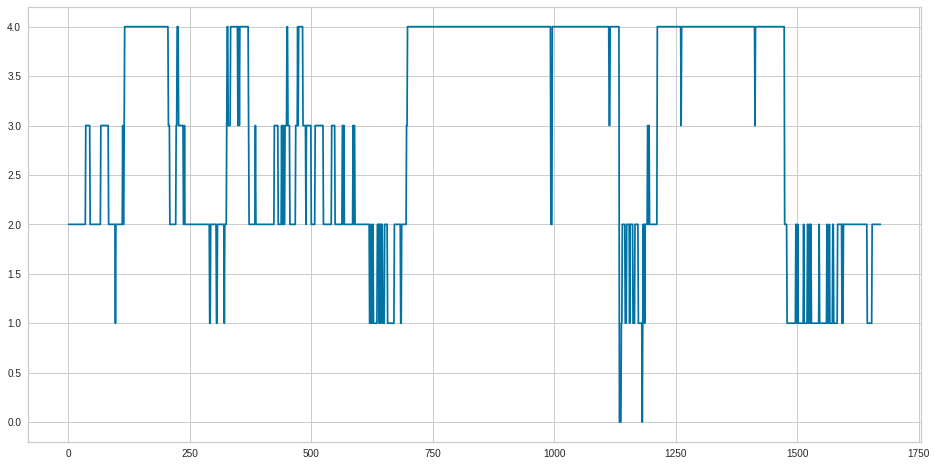

In [205]:
DF2019.drop('hour',axis=1,inplace=True)
DF2018.drop('hour',axis=1,inplace=True)
DF2018.reset_index(drop=True, inplace=True)
DF2019.reset_index(drop=True, inplace=True)
DFcom=pd.concat([DF2018, DF2019], axis=0)

labelscom=DFcom['NO2'].values
templcom=set_tags_no2(labelscom)
DFcom.NO2=templcom
DFcom.fillna(0,inplace=True)

#now we have to rank the labels to numbers to
uncoded_Y=DFcom.NO2.values
Coded_Y=np.zeros(uncoded_Y.shape)
for i in range(len(uncoded_Y)):
  if(uncoded_Y[i]=='Good'):
    Coded_Y[i]=0
  elif(uncoded_Y[i]=='Moderate'):
    Coded_Y[i]=1
  elif(uncoded_Y[i]=='Unhealthy for sensitive group'):
    Coded_Y[i]=2
  elif(uncoded_Y[i]=='Unhealthy'):
    Coded_Y[i]=3
  elif(uncoded_Y[i]=='Very unhealthy'):
    Coded_Y[i]=4
DFcom.NO2=Coded_Y


DF18=DFcom.loc[DFcom['year']==2018]
DF19=DFcom.loc[DFcom['year']==2019]
date18=[]
for i in range(len(DF18)):
  date18.append(i+1)
DF18.drop(['year','month','day'],axis=1,inplace=True)
DF18['date_by_day']=date18

date19=[]
for i in range(len(DF19)):
  date19.append(i+1)
DF19.drop(['year','month','day'],axis=1,inplace=True)
DF19['date_by_day']=date19

dateco=[]
for i in range(len(DFcom)):
  dateco.append(i+1)
DFcom.drop(['year','month','day'],axis=1,inplace=True)
DFcom['date_by_day']=dateco

# print(trainDf.columns)
#as testing is based on date
DF18.index = DF18['date_by_day']
DF18=DF18.sort_index(ascending=True, axis=0)
DF19.index = DF19['date_by_day']
DF19=DF19.sort_index(ascending=True, axis=0)
DFcom.index = DFcom['date_by_day']
DFcom=DFcom.sort_index(ascending=True, axis=0)
plt.figure(figsize=(16,8))
plt.plot(DF18['NO2'], label='NO2 level')



#devide 2018 , 19 , mix dataset to train and test
trainxcom,testxcom,trainycom,testycom=tts(DFcom.drop('NO2', axis=1),DFcom['NO2'],test_size=0.30,random_state=300)
trainx18,testx18,trainy18,testy18=tts(DF18.drop('NO2', axis=1),DF18['NO2'],test_size=0.30,random_state=300)
trainx19,testx19,trainy19,testy19=tts(DF19.drop('NO2', axis=1),DF19['NO2'],test_size=0.30,random_state=300)





#process 2018 data for lstm
scaler = MinMaxScaler(feature_range=(0, 1))
values18 = scaler.fit_transform(trainx18)
trainx18 = series_to_supervised(values18, 1, 1)
tsvalues18 = scaler.fit_transform(testx18)
testx18 = series_to_supervised(tsvalues18, 1, 1)
testlab18=testy18
trainlab18=trainy18

trainx18=trainx18.values
testx18=testx18.values
trainlab18=trainlab18[1:]
testlab18=testlab18[1:]
trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
testx18 = testx18.reshape((testx18.shape[0], 1, testx18.shape[1]))
print(trainx18.shape, trainlab18.shape, testx18.shape, testlab18.shape)




#process 2019 data for lstm
scaler = MinMaxScaler(feature_range=(0, 1))
values19 = scaler.fit_transform(trainx19)
trainx19 = series_to_supervised(values19, 1, 1)
tsvalues19 = scaler.fit_transform(testx19)
testx19 = series_to_supervised(tsvalues19, 1, 1)
testlab19=testy19
trainlab19=trainy19

trainx19=trainx19.values
testx19=testx19.values
trainlab19=trainlab19[:-1]
testlab19=testlab19[:-1]
trainx19 = trainx19.reshape((trainx19.shape[0], 1, trainx19.shape[1]))
testx19 = testx19.reshape((testx19.shape[0], 1, testx19.shape[1]))
print(trainx19.shape, trainlab19.shape, testx19.shape, testlab19.shape)




#process mix data for lstm
scaler = MinMaxScaler(feature_range=(0, 1))
valuescom = scaler.fit_transform(trainxcom)
trainxcom = series_to_supervised(valuescom, 1, 1)
tsvaluescom = scaler.fit_transform(testxcom)
testxcom = series_to_supervised(tsvaluescom, 1, 1)
testlabcom=testycom
trainlabcom=trainycom

trainxcom=trainxcom.values
testxcom=testxcom.values
trainlabcom=trainlabcom[:-1]
testlabcom=testlabcom[:-1]
trainxcom = trainxcom.reshape((trainxcom.shape[0], 1, trainxcom.shape[1]))
testxcom = testxcom.reshape((testxcom.shape[0], 1, testxcom.shape[1]))
print(trainxcom.shape, trainlabcom.shape, testxcom.shape, testlabcom.shape)



LSTM

Epoch 1/500
17/17 - 3s - loss: 2.7415 - val_loss: 2.4250 - 3s/epoch - 157ms/step
Epoch 2/500
17/17 - 0s - loss: 2.0934 - val_loss: 1.7006 - 93ms/epoch - 5ms/step
Epoch 3/500
17/17 - 0s - loss: 1.3925 - val_loss: 1.1203 - 77ms/epoch - 5ms/step
Epoch 4/500
17/17 - 0s - loss: 1.0857 - val_loss: 1.0112 - 76ms/epoch - 4ms/step
Epoch 5/500
17/17 - 0s - loss: 1.0395 - val_loss: 1.0070 - 86ms/epoch - 5ms/step
Epoch 6/500
17/17 - 0s - loss: 1.0309 - val_loss: 1.0017 - 100ms/epoch - 6ms/step
Epoch 7/500
17/17 - 0s - loss: 1.0233 - val_loss: 0.9929 - 100ms/epoch - 6ms/step
Epoch 8/500
17/17 - 0s - loss: 1.0160 - val_loss: 0.9864 - 83ms/epoch - 5ms/step
Epoch 9/500
17/17 - 0s - loss: 1.0087 - val_loss: 0.9804 - 95ms/epoch - 6ms/step
Epoch 10/500
17/17 - 0s - loss: 1.0013 - val_loss: 0.9738 - 78ms/epoch - 5ms/step
Epoch 11/500
17/17 - 0s - loss: 0.9937 - val_loss: 0.9663 - 81ms/epoch - 5ms/step
Epoch 12/500
17/17 - 0s - loss: 0.9860 - val_loss: 0.9592 - 100ms/epoch - 6ms/step
Epoch 13/500
17/17 - 0

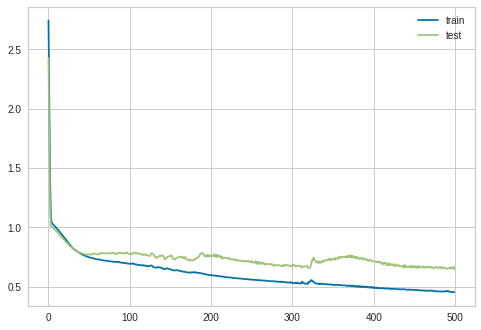

Epoch 1/500
3/3 - 2s - loss: 1.7924 - val_loss: 1.7269 - 2s/epoch - 820ms/step
Epoch 2/500
3/3 - 0s - loss: 1.7338 - val_loss: 1.6692 - 34ms/epoch - 11ms/step
Epoch 3/500
3/3 - 0s - loss: 1.6746 - val_loss: 1.6103 - 33ms/epoch - 11ms/step
Epoch 4/500
3/3 - 0s - loss: 1.6139 - val_loss: 1.5494 - 40ms/epoch - 13ms/step
Epoch 5/500
3/3 - 0s - loss: 1.5511 - val_loss: 1.4858 - 31ms/epoch - 10ms/step
Epoch 6/500
3/3 - 0s - loss: 1.4851 - val_loss: 1.4185 - 31ms/epoch - 10ms/step
Epoch 7/500
3/3 - 0s - loss: 1.4152 - val_loss: 1.3468 - 35ms/epoch - 12ms/step
Epoch 8/500
3/3 - 0s - loss: 1.3407 - val_loss: 1.2701 - 38ms/epoch - 13ms/step
Epoch 9/500
3/3 - 0s - loss: 1.2608 - val_loss: 1.1882 - 41ms/epoch - 14ms/step
Epoch 10/500
3/3 - 0s - loss: 1.1749 - val_loss: 1.1057 - 37ms/epoch - 12ms/step
Epoch 11/500
3/3 - 0s - loss: 1.0853 - val_loss: 1.0234 - 37ms/epoch - 12ms/step
Epoch 12/500
3/3 - 0s - loss: 0.9951 - val_loss: 0.9416 - 36ms/epoch - 12ms/step
Epoch 13/500
3/3 - 0s - loss: 0.9110 -

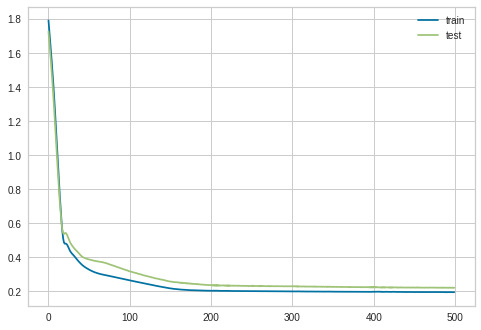

Epoch 1/500
19/19 - 3s - loss: 2.4109 - val_loss: 2.1096 - 3s/epoch - 142ms/step
Epoch 2/500
19/19 - 0s - loss: 1.6675 - val_loss: 1.2941 - 81ms/epoch - 4ms/step
Epoch 3/500
19/19 - 0s - loss: 1.0832 - val_loss: 0.9454 - 102ms/epoch - 5ms/step
Epoch 4/500
19/19 - 0s - loss: 0.9845 - val_loss: 0.9238 - 96ms/epoch - 5ms/step
Epoch 5/500
19/19 - 0s - loss: 0.9747 - val_loss: 0.9140 - 98ms/epoch - 5ms/step
Epoch 6/500
19/19 - 0s - loss: 0.9630 - val_loss: 0.9057 - 90ms/epoch - 5ms/step
Epoch 7/500
19/19 - 0s - loss: 0.9534 - val_loss: 0.8957 - 102ms/epoch - 5ms/step
Epoch 8/500
19/19 - 0s - loss: 0.9444 - val_loss: 0.8856 - 100ms/epoch - 5ms/step
Epoch 9/500
19/19 - 0s - loss: 0.9359 - val_loss: 0.8767 - 88ms/epoch - 5ms/step
Epoch 10/500
19/19 - 0s - loss: 0.9286 - val_loss: 0.8683 - 110ms/epoch - 6ms/step
Epoch 11/500
19/19 - 0s - loss: 0.9221 - val_loss: 0.8609 - 104ms/epoch - 5ms/step
Epoch 12/500
19/19 - 0s - loss: 0.9163 - val_loss: 0.8545 - 142ms/epoch - 7ms/step
Epoch 13/500
19/19 

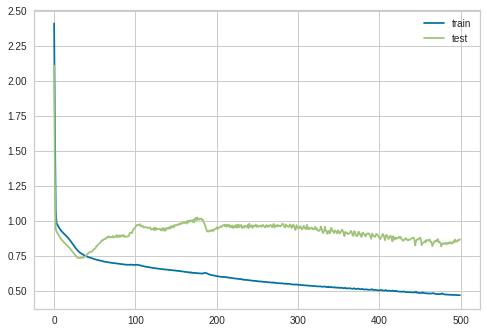

In [206]:
#2018
model18 = Sequential()
model18.add(LSTM(50, input_shape=(trainx18.shape[1], trainx18.shape[2])))
model18.add(Dense(1))
model18.compile(loss='mae', optimizer='adam')
# fit network
#, 
history18pre = model18.fit(trainx18, trainlab18, epochs=500,validation_data=(testx18, testlab18), batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history18pre.history['loss'], label='train')
plt.plot(history18pre.history['val_loss'], label='test')
plt.legend()
plt.show()

#2019
model19 = Sequential()
model19.add(LSTM(50, input_shape=(trainx19.shape[1], trainx19.shape[2])))
model19.add(Dense(1))
model19.compile(loss='mae', optimizer='adam')
# fit network
#, 
history19pre = model19.fit(trainx19, trainlab19, epochs=500,validation_data=(testx19, testlab19), batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history19pre.history['loss'], label='train')
plt.plot(history19pre.history['val_loss'], label='test')
plt.legend()
plt.show()

#mix
modelc = Sequential()
modelc.add(LSTM(50, input_shape=(trainxcom.shape[1], trainxcom.shape[2])))
modelc.add(Dense(1))
modelc.compile(loss='mae', optimizer='adam')
# fit network
#, 
historycpre = modelc.fit(trainxcom, trainlabcom, epochs=500,validation_data=(testxcom, testlabcom), batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(historycpre.history['loss'], label='train')
plt.plot(historycpre.history['val_loss'], label='test')
plt.legend()
plt.show()



evaluation on 2019

In [207]:
from sklearn.metrics import mean_squared_error
yhat18 = model18.predict(testx18)

rmse18 = np.sqrt(mean_squared_error(testlab18, yhat18))
print('Test RMSE for 2018: %.3f' % rmse18)

yhat19 = model19.predict(testx19)

rmse19 = np.sqrt(mean_squared_error(testlab19, yhat19))
print('Test RMSE for 2019: %.3f' % rmse19)

yhatc = modelc.predict(testxcom)

rmsec = np.sqrt(mean_squared_error(testlabcom, yhatc))
print('Test RMSE for mix data: %.3f' % rmsec)

Test RMSE for 2018: 0.930
Test RMSE for 2019: 0.483
Test RMSE for mix data: 1.102


prediction based on day

In [208]:
predict_these=[2,8,10,20,30,40,50,60,70]
ys=model18.predict(testx18[predict_these,:,:])
testlab18=testlab18.values.tolist()
for i in range(len(predict_these)):
  print('predicted ',np.round(ys[i]),'for day',predict_these[i],'of 2018. the true value is',testlab18[predict_these[i]])

print("\n")
ys=model19.predict(testx19[predict_these,:,:])
testlab19=testlab19.values.tolist()
for i in range(len(predict_these)):
  print('predicted ',np.round(ys[i]),'for day',predict_these[i],'of 2019. the true value is',testlab19[predict_these[i]])

print("\n")
ys=modelc.predict(testxcom[predict_these,:,:])
testlabcom=testlabcom.values.tolist()
for i in range(len(predict_these)):
  print('predicted ',np.round(ys[i]),'for day',predict_these[i],'of mix2019. the true value is',testlabcom[predict_these[i]])

predicted  [3.] for day 2 of 2018. the true value is 1.0
predicted  [3.] for day 8 of 2018. the true value is 2.0
predicted  [4.] for day 10 of 2018. the true value is 4.0
predicted  [3.] for day 20 of 2018. the true value is 4.0
predicted  [4.] for day 30 of 2018. the true value is 4.0
predicted  [2.] for day 40 of 2018. the true value is 1.0
predicted  [3.] for day 50 of 2018. the true value is 2.0
predicted  [4.] for day 60 of 2018. the true value is 4.0
predicted  [3.] for day 70 of 2018. the true value is 2.0


predicted  [2.] for day 2 of 2019. the true value is 2.0
predicted  [2.] for day 8 of 2019. the true value is 2.0
predicted  [2.] for day 10 of 2019. the true value is 2.0
predicted  [2.] for day 20 of 2019. the true value is 2.0
predicted  [2.] for day 30 of 2019. the true value is 2.0
predicted  [2.] for day 40 of 2019. the true value is 2.0
predicted  [2.] for day 50 of 2019. the true value is 2.0
predicted  [2.] for day 60 of 2019. the true value is 2.0
predicted  [2.] 

#prediction based on month feature sequence before policy

[ 1  2  3  4 10 11 12]


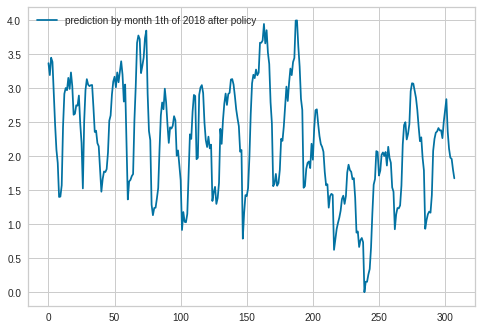

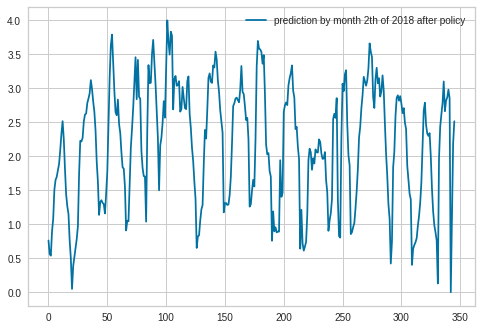

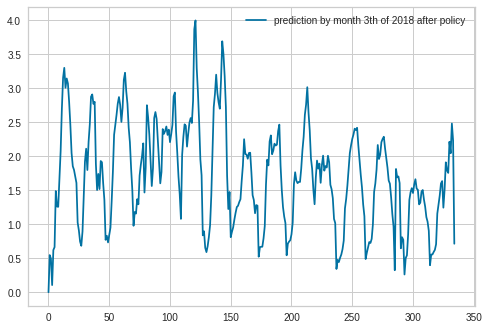

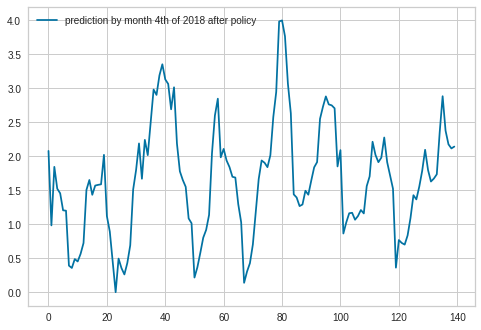

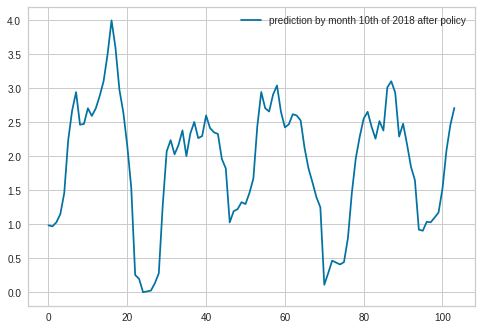

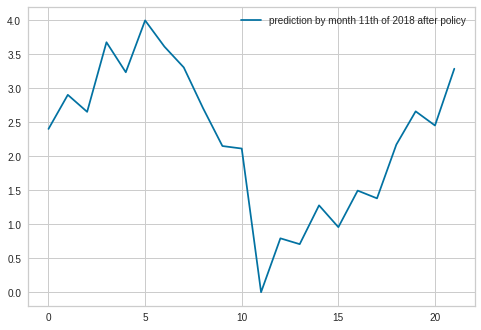

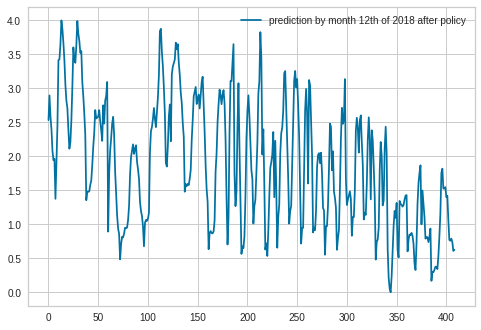

In [209]:
DF18=pd.read_csv('mix2018.csv')
monthvals=DF18.month.unique()


tf=DF18['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF18['two_wheeled_motor_vehicles']=twmv
DF18['cars_and_taxis']=cat
DF18['buses_and_coaches']=bac
DF18['lgvs']=lgvs
DF18.drop('Traffic Flow',axis=1)
labels2018=DF18['NO2']
templ2018=set_tags_no2(labels2018)
DF18.NO2=templ2018
Ys=DF18["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF18.NO2=Ys_of_train


print(monthvals)
for j in monthvals:

  tempdf=DF18.loc[DF2018['month'] == j]
  trainx18=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values18 = scaler.fit_transform(trainx18)
  trainx18 = series_to_supervised(values18, 1, 1)
  trainlab18=tempdf['NO2'].values

  trainx18=trainx18.values
  trainlab18=trainlab18[:48]
  trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
  trainx18 =trainx18[:,:,:48]
  yhats = model18.predict(trainx18)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats = scaler.fit_transform(yhats)
  plt.plot(yhats, label='prediction by month '+str(j)+'th of 2018 after policy')
  plt.legend()
  plt.show()




  


[1 3]


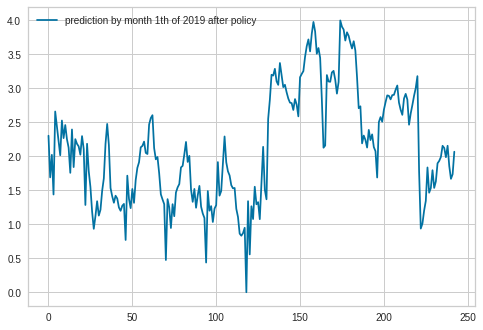

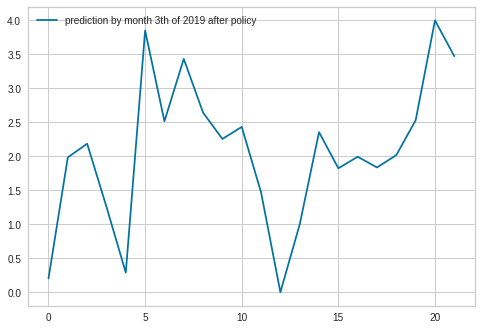

In [210]:
DF19=pd.read_csv('mix2019.csv')
monthvals=DF19.month.unique()


tf=DF19['Congestion'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1913)
DF19['two_wheeled_motor_vehicles']=twmv
DF19['cars_and_taxis']=cat
DF19['buses_and_coaches']=bac
DF19['lgvs']=lgvs
DF19.drop("Congestion",axis=1)

labels2019=DF19['NO2']
templ2019=set_tags_no2(labels2019)
DF19.NO2=templ2019
Ys=DF19["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF19.NO2=Ys_of_train


print(monthvals)
for j in monthvals:

  tempdf=DF19.loc[DF2019['month'] == j]
  trainx19=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values19 = scaler.fit_transform(trainx19)
  trainx19 = series_to_supervised(values19, 1, 1)
  trainlab19=tempdf['NO2'].values

  trainx19=trainx19.values
  trainlab19=trainlab19[:40]
  trainx19 = trainx19.reshape((trainx19.shape[0], 1, trainx19.shape[1]))
  trainx19 =trainx19[:,:,:40]
  tr=np.zeros((trainx19.shape[0],trainx19.shape[1],48))
  tr[:,:,:trainx19.shape[2]]=trainx19
  yhats = model19.predict(tr)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats = scaler.fit_transform(yhats)
  plt.plot(yhats, label='prediction by month '+str(j)+'th of 2019 after policy')
  plt.legend()
  plt.show()





manipulation number of traffic flow

In [211]:
DFcom.columns

Index(['Rain Duration', 'Solar Radiation', 'Particle Count', 'Max Wind Speed',
       'Average Speed', 'Solar Diffuse Radiation', 'O3', 'PM2_5', 'Wind Speed',
       'Pressure', 'Brood', 'NO', 'NOx', 'PM 4', 'PM10', 'Wind Direction',
       'Rain Acc', 'CO', 'PM1', 'NO2', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'date_by_day'],
      dtype='object')

In [212]:
#first import datasets
DF18=pd.read_csv('mix2018.csv')
# print(DF2018.head())
DF19=pd.read_csv('mix2019.csv')
# print(DF2019.head())
DF18.reset_index(drop=True, inplace=True)
DF19.reset_index(drop=True, inplace=True)

tf=DF18['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF18['two_wheeled_motor_vehicles']=twmv
DF18['cars_and_taxis']=cat
DF18['buses_and_coaches']=bac
DF18['lgvs']=lgvs

tf=DF19['Congestion'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF19['two_wheeled_motor_vehicles']=twmv
DF19['cars_and_taxis']=cat
DF19['buses_and_coaches']=bac
DF19['lgvs']=lgvs
DF18=DF18.drop('Traffic Flow',axis=1)
DF18=DF18.drop('Congestion',axis=1)
DF19=DF19.drop('Congestion',axis=1)


DF19.drop('hour',axis=1,inplace=True)
DF18.drop('hour',axis=1,inplace=True)
DF18.reset_index(drop=True, inplace=True)
DF19.reset_index(drop=True, inplace=True)
DFcom=pd.concat([DF18, DF19], axis=0)




# manipulation
#combined
twmvc=DFcom["two_wheeled_motor_vehicles"].values
twmvc=np.round(twmvc*0.8)
catc=DFcom["cars_and_taxis"].values
catc=np.round(catc*0.8)
bacc=DFcom["buses_and_coaches"].values
bacc=np.round(bacc*0.9)
lgvsc=DFcom["lgvs"].values
lgvsc=np.round(lgvsc*0.8)
coc=DFcom["CO"].values
coc=coc-18
pm25c=DFcom["PM2_5"].values
pm25c=pm25c -16
parc=DFcom["Particle Count"].values
parc=parc -10
pm1c=DFcom["PM1"].values
pm1c=pm1c -10
pm10c=DFcom["PM10"].values
pm10c=pm10c -21
pm4c=DFcom["PM 4"].values
pm4c=pm4c -23
o3c=DFcom["O3"].values
o3c=o3c -29
noc=DFcom["NO"].values
noc=noc -18
noxc=DFcom["NOx"].values
noxc=noxc -24
no2c=DFcom["NO2"].values
no2c=no2c -25


DFcom["two_wheeled_motor_vehicles"]=twmvc
DFcom["cars_and_taxis"]=catc
DFcom["buses_and_coaches"]=bacc
DFcom["lgvs"]=lgvsc
DFcom["CO"]=coc
DFcom["PM2_5"]=pm25c
DFcom["Particle Count"]=parc
DFcom["PM1"]=pm1c
DFcom["PM10"]=pm10c
DFcom["PM 4"]=pm4c
DFcom["O3"]=o3c
DFcom["NO"]=noc
DFcom["NOx"]=noxc
DFcom["NO2"]=no2c



# 18
twmv18=DF18["two_wheeled_motor_vehicles"].values
twmv18=np.round(twmv18*0.8)
cat18=DF18["cars_and_taxis"].values
cat18=np.round(cat18*0.8)
bac18=DF18["buses_and_coaches"].values
bac18=np.round(bac18*0.9)
lgvs18=DF18["lgvs"].values
lgvs18=np.round(lgvs18*0.8)
co18=DF18["CO"].values
co18=co18-18
pm2518=DF18["PM2_5"].values
pm2518=pm2518 -16
par18=DF18["Particle Count"].values
par18=par18 -10
pm118=DF18["PM1"].values
pm118=pm118 -10
pm1018=DF18["PM10"].values
pm1018=pm1018 -21
pm418=DF18["PM 4"].values
pm418=pm418 -23
o318=DF18["O3"].values
o318=o318 -29
no18=DF18["NO"].values
no18=no18 -18
nox18=DF18["NOx"].values
nox18=nox18 -24
no218=DF18["NO2"].values
no218=no218 -25


DF18["two_wheeled_motor_vehicles"]=twmv18
DF18["cars_and_taxis"]=cat18
DF18["buses_and_coaches"]=bac18
DF18["lgvs"]=lgvs18
DF18["CO"]=co18
DF18["PM2_5"]=pm2518
DF18["Particle Count"]=par18
DF18["PM1"]=pm118
DF18["PM10"]=pm1018
DF18["PM 4"]=pm418
DF18["O3"]=o318
DF18["NO"]=no18
DF18["NOx"]=nox18
DF18["NO2"]=no218

# 19
twmv19=DF19["two_wheeled_motor_vehicles"].values
twmv19=np.round(twmv19*0.8)
cat19=DF19["cars_and_taxis"].values
cat19=np.round(cat19*0.8)
bac19=DF19["buses_and_coaches"].values
bac19=np.round(bac19*0.9)
lgvs19=DF19["lgvs"].values
lgvs19=np.round(lgvs19*0.8)
co19=DF19["CO"].values
co19=co19-18
# pm2519=DF19["PM2_5"].values
# pm2519=pm2519 -16
par19=DF19["Particle Count"].values
par19=par19 -10
pm119=DF19["PM1"].values
pm119=pm119 -10
pm1019=DF19["PM10"].values
pm1019=pm1019 -21
pm419=DF19["PM 4"].values
pm419=pm419 -23
# o319=DF19["O3"].values
# o319=o319 -29
no19=DF19["NO"].values
no19=no19 -18
nox19=DF19["NOx"].values
nox19=nox19 -24
no219=DF19["NO2"].values
no219=no219 -25


DF19["two_wheeled_motor_vehicles"]=twmv19
DF19["cars_and_taxis"]=cat19
DF19["buses_and_coaches"]=bac19
DF19["lgvs"]=lgvs19
DF19["CO"]=co19
# DF19["PM2_5"]=pm2519
DF19["Particle Count"]=par19
DF19["PM1"]=pm119
DF19["PM10"]=pm1019
DF19["PM 4"]=pm419
# DF19["O3"]=o319
DF19["NO"]=no19
DF19["NOx"]=nox19
DF19["NO2"]=no219
#setting labels
labelscom=DFcom['NO2'].values
templcom=set_tags_no2(labelscom)
DFcom.NO2=templcom
DFcom.fillna(0,inplace=True)

labels18=DF18['NO2'].values
templ18=set_tags_no2(labels18)
DF18.NO2=templ18
DF18.fillna(0,inplace=True)

labels19=DF19['NO2'].values
templ19=set_tags_no2(labels19)
DF19.NO2=templ19
DF19.fillna(0,inplace=True)

uncoded_Y=DFcom.NO2.values
Coded_Y=np.zeros(uncoded_Y.shape)
for i in range(len(uncoded_Y)):
  if(uncoded_Y[i]=='Good'):
    Coded_Y[i]=0
  elif(uncoded_Y[i]=='Moderate'):
    Coded_Y[i]=1
  elif(uncoded_Y[i]=='Unhealthy for sensitive group'):
    Coded_Y[i]=2
  elif(uncoded_Y[i]=='Unhealthy'):
    Coded_Y[i]=3
  elif(uncoded_Y[i]=='Very unhealthy'):
    Coded_Y[i]=4
DFcom.NO2=Coded_Y

uncoded_Y=DF18.NO2.values
Coded_Y=np.zeros(uncoded_Y.shape)
for i in range(len(uncoded_Y)):
  if(uncoded_Y[i]=='Good'):
    Coded_Y[i]=0
  elif(uncoded_Y[i]=='Moderate'):
    Coded_Y[i]=1
  elif(uncoded_Y[i]=='Unhealthy for sensitive group'):
    Coded_Y[i]=2
  elif(uncoded_Y[i]=='Unhealthy'):
    Coded_Y[i]=3
  elif(uncoded_Y[i]=='Very unhealthy'):
    Coded_Y[i]=4
DF18.NO2=Coded_Y

uncoded_Y=DF19.NO2.values
Coded_Y=np.zeros(uncoded_Y.shape)
for i in range(len(uncoded_Y)):
  if(uncoded_Y[i]=='Good'):
    Coded_Y[i]=0
  elif(uncoded_Y[i]=='Moderate'):
    Coded_Y[i]=1
  elif(uncoded_Y[i]=='Unhealthy for sensitive group'):
    Coded_Y[i]=2
  elif(uncoded_Y[i]=='Unhealthy'):
    Coded_Y[i]=3
  elif(uncoded_Y[i]=='Very unhealthy'):
    Coded_Y[i]=4
DF19.NO2=Coded_Y


#number of very unhealthy after policy
Af19=DF19.NO2.values

Af18=DF18.NO2.values

Afc=DFcom.NO2.values





#devide 2018 , 19 , mix dataset to train and test
trainxcom,testxcom,trainycom,testycom=tts(DFcom.drop('NO2', axis=1),DFcom['NO2'],test_size=0.30,random_state=300)
trainx18,testx18,trainy18,testy18=tts(DF18.drop('NO2', axis=1),DF18['NO2'],test_size=0.30,random_state=300)
trainx19,testx19,trainy19,testy19=tts(DF19.drop('NO2', axis=1),DF19['NO2'],test_size=0.30,random_state=300)




#process 2018 data for lstm
scaler = MinMaxScaler(feature_range=(0, 1))
values18 = scaler.fit_transform(trainx18)
trainx18 = series_to_supervised(values18, 1, 1)
tsvalues18 = scaler.fit_transform(testx18)
testx18 = series_to_supervised(tsvalues18, 1, 1)
testlab18=testy18
trainlab18=trainy18

trainx18=trainx18.values
testx18=testx18.values
trainlab18=trainlab18[1:]
testlab18=testlab18[1:]
trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
testx18 = testx18.reshape((testx18.shape[0], 1, testx18.shape[1]))
print(trainx18.shape, trainlab18.shape, testx18.shape, testlab18.shape)




#process 2019 data for lstm
scaler = MinMaxScaler(feature_range=(0, 1))
values19 = scaler.fit_transform(trainx19)
trainx19 = series_to_supervised(values19, 1, 1)
tsvalues19 = scaler.fit_transform(testx19)
testx19 = series_to_supervised(tsvalues19, 1, 1)
testlab19=testy19
trainlab19=trainy19

trainx19=trainx19.values
testx19=testx19.values
trainlab19=trainlab19[:-1]
testlab19=testlab19[:-1]
trainx19 = trainx19.reshape((trainx19.shape[0], 1, trainx19.shape[1]))
testx19 = testx19.reshape((testx19.shape[0], 1, testx19.shape[1]))
print(trainx19.shape, trainlab19.shape, testx19.shape, testlab19.shape)




#process mix data for lstm
scaler = MinMaxScaler(feature_range=(0, 1))
valuescom = scaler.fit_transform(trainxcom)
trainxcom = series_to_supervised(valuescom, 1, 1)
tsvaluescom = scaler.fit_transform(testxcom)
testxcom = series_to_supervised(tsvaluescom, 1, 1)
testlabcom=testycom
trainlabcom=trainycom

trainxcom=trainxcom.values
testxcom=testxcom.values
trainlabcom=trainlabcom[:-1]
testlabcom=testlabcom[:-1]
trainxcom = trainxcom.reshape((trainxcom.shape[0], 1, trainxcom.shape[1]))
testxcom = testxcom.reshape((testxcom.shape[0], 1, testxcom.shape[1]))
print(DF18["NO2"].values, DF19["NO2"].values, DFcom["NO2"].values)




(1168, 1, 52) (1168,) (501, 1, 52) (501,)
(185, 1, 36) (185,) (80, 1, 36) (80,)
[1. 1. 0. ... 1. 1. 1.] [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 2. 2. 2. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] [1. 1. 0. ... 0. 0. 0.]


train manipulated data

Epoch 1/500
17/17 - 3s - loss: 2.2655 - val_loss: 2.0471 - 3s/epoch - 162ms/step
Epoch 2/500
17/17 - 0s - loss: 1.8270 - val_loss: 1.6258 - 89ms/epoch - 5ms/step
Epoch 3/500
17/17 - 0s - loss: 1.5286 - val_loss: 1.4039 - 82ms/epoch - 5ms/step
Epoch 4/500
17/17 - 0s - loss: 1.4255 - val_loss: 1.3841 - 93ms/epoch - 5ms/step
Epoch 5/500
17/17 - 0s - loss: 1.4136 - val_loss: 1.3728 - 100ms/epoch - 6ms/step
Epoch 6/500
17/17 - 0s - loss: 1.4012 - val_loss: 1.3613 - 107ms/epoch - 6ms/step
Epoch 7/500
17/17 - 0s - loss: 1.3893 - val_loss: 1.3494 - 107ms/epoch - 6ms/step
Epoch 8/500
17/17 - 0s - loss: 1.3776 - val_loss: 1.3364 - 98ms/epoch - 6ms/step
Epoch 9/500
17/17 - 0s - loss: 1.3650 - val_loss: 1.3217 - 103ms/epoch - 6ms/step
Epoch 10/500
17/17 - 0s - loss: 1.3510 - val_loss: 1.3064 - 87ms/epoch - 5ms/step
Epoch 11/500
17/17 - 0s - loss: 1.3357 - val_loss: 1.2903 - 106ms/epoch - 6ms/step
Epoch 12/500
17/17 - 0s - loss: 1.3192 - val_loss: 1.2732 - 94ms/epoch - 6ms/step
Epoch 13/500
17/17 -

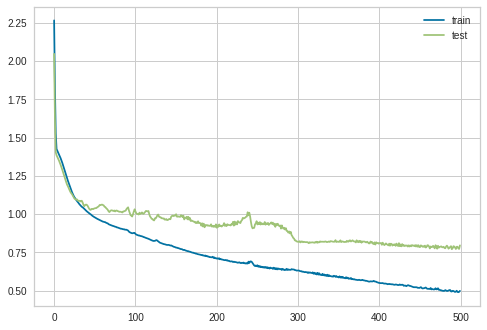

Epoch 1/500
3/3 - 3s - loss: 0.7788 - val_loss: 0.7609 - 3s/epoch - 844ms/step
Epoch 2/500
3/3 - 0s - loss: 0.7426 - val_loss: 0.7274 - 31ms/epoch - 10ms/step
Epoch 3/500
3/3 - 0s - loss: 0.7124 - val_loss: 0.6944 - 40ms/epoch - 13ms/step
Epoch 4/500
3/3 - 0s - loss: 0.6817 - val_loss: 0.6605 - 30ms/epoch - 10ms/step
Epoch 5/500
3/3 - 0s - loss: 0.6500 - val_loss: 0.6252 - 32ms/epoch - 11ms/step
Epoch 6/500
3/3 - 0s - loss: 0.6170 - val_loss: 0.5883 - 32ms/epoch - 11ms/step
Epoch 7/500
3/3 - 0s - loss: 0.5824 - val_loss: 0.5495 - 41ms/epoch - 14ms/step
Epoch 8/500
3/3 - 0s - loss: 0.5460 - val_loss: 0.5085 - 38ms/epoch - 13ms/step
Epoch 9/500
3/3 - 0s - loss: 0.5075 - val_loss: 0.4689 - 41ms/epoch - 14ms/step
Epoch 10/500
3/3 - 0s - loss: 0.4670 - val_loss: 0.4364 - 30ms/epoch - 10ms/step
Epoch 11/500
3/3 - 0s - loss: 0.4323 - val_loss: 0.4210 - 31ms/epoch - 10ms/step
Epoch 12/500
3/3 - 0s - loss: 0.4191 - val_loss: 0.4228 - 30ms/epoch - 10ms/step
Epoch 13/500
3/3 - 0s - loss: 0.4232 -

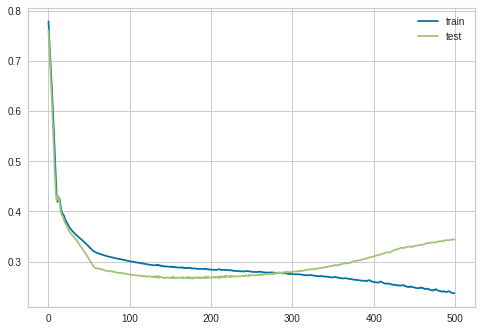

Epoch 1/500
19/19 - 3s - loss: 2.0653 - val_loss: 1.9509 - 3s/epoch - 140ms/step
Epoch 2/500
19/19 - 0s - loss: 1.6448 - val_loss: 1.4991 - 93ms/epoch - 5ms/step
Epoch 3/500
19/19 - 0s - loss: 1.4152 - val_loss: 1.3275 - 82ms/epoch - 4ms/step
Epoch 4/500
19/19 - 0s - loss: 1.3493 - val_loss: 1.2985 - 100ms/epoch - 5ms/step
Epoch 5/500
19/19 - 0s - loss: 1.3233 - val_loss: 1.2749 - 99ms/epoch - 5ms/step
Epoch 6/500
19/19 - 0s - loss: 1.2979 - val_loss: 1.2510 - 97ms/epoch - 5ms/step
Epoch 7/500
19/19 - 0s - loss: 1.2761 - val_loss: 1.2268 - 100ms/epoch - 5ms/step
Epoch 8/500
19/19 - 0s - loss: 1.2576 - val_loss: 1.2071 - 84ms/epoch - 4ms/step
Epoch 9/500
19/19 - 0s - loss: 1.2439 - val_loss: 1.1914 - 101ms/epoch - 5ms/step
Epoch 10/500
19/19 - 0s - loss: 1.2320 - val_loss: 1.1766 - 100ms/epoch - 5ms/step
Epoch 11/500
19/19 - 0s - loss: 1.2202 - val_loss: 1.1628 - 97ms/epoch - 5ms/step
Epoch 12/500
19/19 - 0s - loss: 1.2074 - val_loss: 1.1472 - 102ms/epoch - 5ms/step
Epoch 13/500
19/19 -

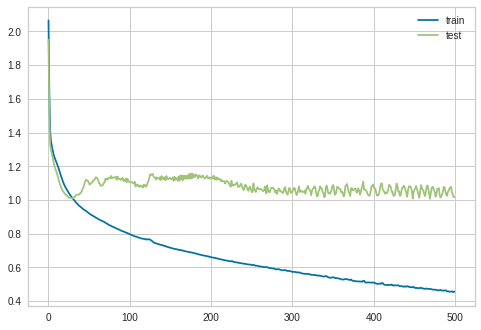

In [213]:
#2018
model18a = Sequential()
model18a.add(LSTM(50, input_shape=(trainx18.shape[1], trainx18.shape[2])))
model18a.add(Dense(1))
model18a.compile(loss='mae', optimizer='adam')
# fit network
#, 
history18pos = model18a.fit(trainx18, trainlab18, epochs=500,validation_data=(testx18, testlab18), batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history18pos.history['loss'], label='train')
plt.plot(history18pos.history['val_loss'], label='test')
plt.legend()
plt.show()

#2019
model19a = Sequential()
model19a.add(LSTM(50, input_shape=(trainx19.shape[1], trainx19.shape[2])))
model19a.add(Dense(1))
model19a.compile(loss='mae', optimizer='adam')
# fit network
#, 
history19pos = model19a.fit(trainx19, trainlab19, epochs=500,validation_data=(testx19, testlab19), batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history19pos.history['loss'], label='train')
plt.plot(history19pos.history['val_loss'], label='test')
plt.legend()
plt.show()

#mix
modelc = Sequential()
modelc.add(LSTM(50, input_shape=(trainxcom.shape[1], trainxcom.shape[2])))
modelc.add(Dense(1))
modelc.compile(loss='mae', optimizer='adam')
# fit network
#, 
historycpos = modelc.fit(trainxcom, trainlabcom, epochs=500,validation_data=(testxcom, testlabcom), batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(historycpos.history['loss'], label='train')
plt.plot(historycpos.history['val_loss'], label='test')
plt.legend()
plt.show()



evaluate manipulated  data

In [214]:
from sklearn.metrics import mean_squared_error
yhat18af = model18a.predict(testx18)

rmse18 = np.sqrt(mean_squared_error(testlab18, yhat18af))
print('Test RMSE for 2018: %.3f' % rmse18)

yhat19af = model19a.predict(testx19)

rmse19 = np.sqrt(mean_squared_error(testlab19, yhat19af))
print('Test RMSE for 2019: %.3f' % rmse19)

yhatcaf = modelc.predict(testxcom)

rmsec = np.sqrt(mean_squared_error(testlabcom, yhatcaf))
print('Test RMSE for mix data: %.3f' % rmsec)

Test RMSE for 2018: 1.070
Test RMSE for 2019: 0.455
Test RMSE for mix data: 1.267


predict manipulated data

In [215]:
predict_these=[2,8,10,20,30,40,50,60,70]
ys=model18a.predict(testx18[predict_these,:,:])
testlab18=testlab18.values.tolist()
print("\n")
for i in range(len(predict_these)):
  print('predicted ',np.round(ys[i]),'for day',predict_these[i])

print("\n")
ys=model19a.predict(testx19[predict_these,:,:])
testlab19=testlab19.values.tolist()
for i in range(len(predict_these)):
  print('predicted ',np.round(ys[i]),'for day',predict_these[i])

print("\n")
ys=modelc.predict(testxcom[predict_these,:,:])
testlabcom=testlabcom.values.tolist()
for i in range(len(predict_these)):
  print('predicted ',np.round(ys[i]),'for day',predict_these[i])




predicted  [2.] for day 2
predicted  [2.] for day 8
predicted  [4.] for day 10
predicted  [3.] for day 20
predicted  [4.] for day 30
predicted  [0.] for day 40
predicted  [3.] for day 50
predicted  [3.] for day 60
predicted  [2.] for day 70


predicted  [1.] for day 2
predicted  [1.] for day 8
predicted  [0.] for day 10
predicted  [1.] for day 20
predicted  [0.] for day 30
predicted  [1.] for day 40
predicted  [1.] for day 50
predicted  [1.] for day 60
predicted  [1.] for day 70


predicted  [5.] for day 2
predicted  [1.] for day 8
predicted  [4.] for day 10
predicted  [1.] for day 20
predicted  [4.] for day 30
predicted  [1.] for day 40
predicted  [2.] for day 50
predicted  [1.] for day 60
predicted  [3.] for day 70


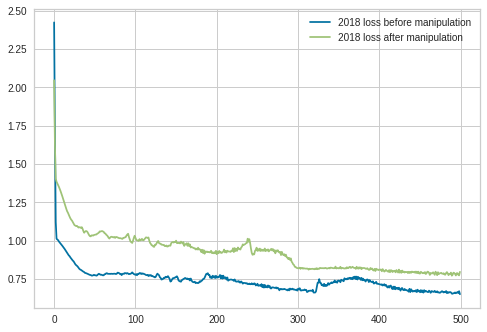

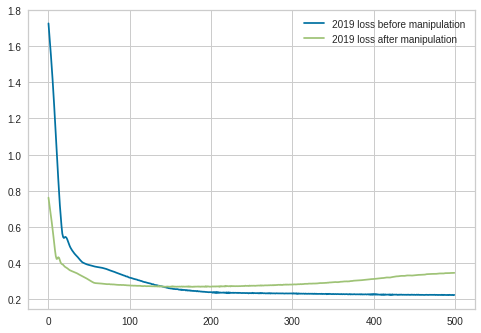

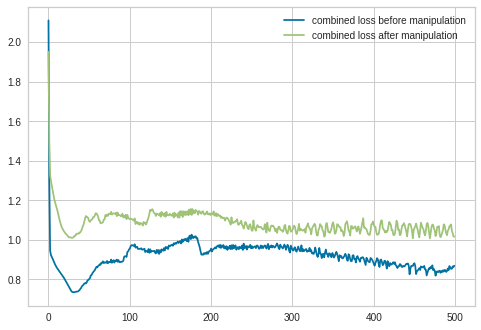

In [216]:
plt.plot(history18pre.history['val_loss'], label='2018 loss before manipulation')
plt.plot(history18pos.history['val_loss'], label='2018 loss after manipulation')
plt.legend()
plt.show()

plt.plot(history19pre.history['val_loss'], label='2019 loss before manipulation')
plt.plot(history19pos.history['val_loss'], label='2019 loss after manipulation')
plt.legend()
plt.show()

plt.plot(historycpre.history['val_loss'], label='combined loss before manipulation')
plt.plot(historycpos.history['val_loss'], label='combined loss after manipulation')
plt.legend()
plt.show()


#LSTM prediction based on months feature sequence after  policy

[ 1  2  3  4 10 11 12]


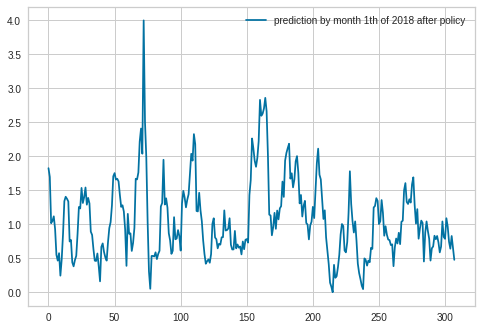

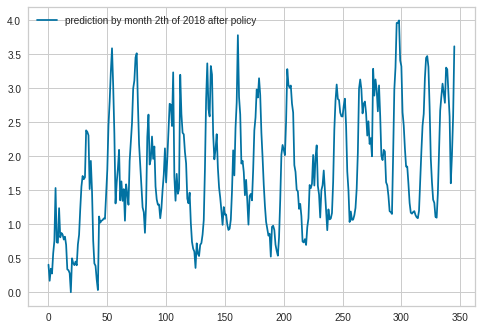

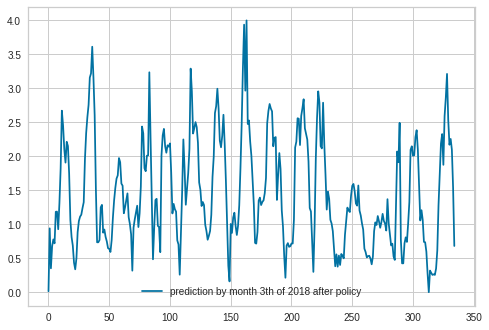

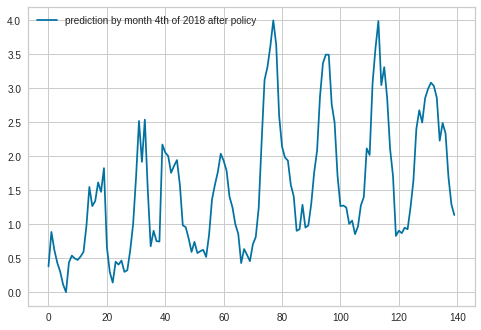

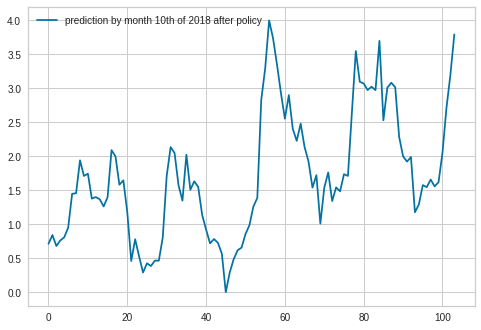

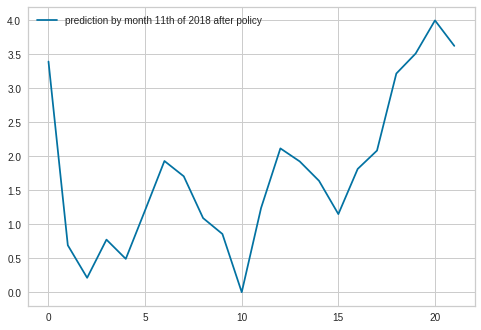

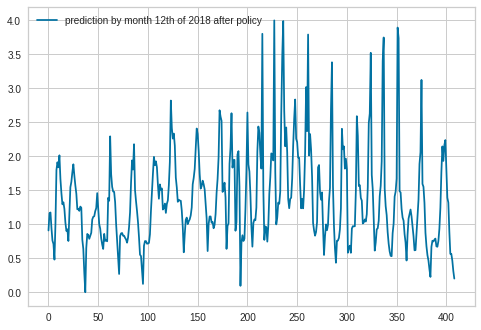

In [217]:
DF18=pd.read_csv('mix2018.csv')
monthvals=DF18.month.unique()


tf=DF18['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF18['two_wheeled_motor_vehicles']=twmv
DF18['cars_and_taxis']=cat
DF18['buses_and_coaches']=bac
DF18['lgvs']=lgvs

# 18
twmv18=DF18["two_wheeled_motor_vehicles"].values
twmv18=np.round(twmv18*0.8)
cat18=DF18["cars_and_taxis"].values
cat18=np.round(cat18*0.8)
bac18=DF18["buses_and_coaches"].values
bac18=np.round(bac18*0.9)
lgvs18=DF18["lgvs"].values
lgvs18=np.round(lgvs18*0.8)
co18=DF18["CO"].values
co18=co18-18
pm2518=DF18["PM2_5"].values
pm2518=pm2518 -16
par18=DF18["Particle Count"].values
par18=par18 -10
pm118=DF18["PM1"].values
pm118=pm118 -10
pm1018=DF18["PM10"].values
pm1018=pm1018 -21
pm418=DF18["PM 4"].values
pm418=pm418 -23
o318=DF18["O3"].values
o318=o318 -29
no18=DF18["NO"].values
no18=no18 -18
nox18=DF18["NOx"].values
nox18=nox18 -24
no218=DF18["NO2"].values
no218=no218 -25


DF18["two_wheeled_motor_vehicles"]=twmv18
DF18["cars_and_taxis"]=cat18
DF18["buses_and_coaches"]=bac18
DF18["lgvs"]=lgvs18
DF18["CO"]=co18
DF18["PM2_5"]=pm2518
DF18["Particle Count"]=par18
DF18["PM1"]=pm118
DF18["PM10"]=pm1018
DF18["PM 4"]=pm418
DF18["O3"]=o318
DF18["NO"]=no18
DF18["NOx"]=nox18
DF18["NO2"]=no218

labels2018=DF18['NO2']
templ2018=set_tags_no2(labels2018)
DF18.NO2=templ2018
Ys=DF18["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF18.NO2=Ys_of_train


print(monthvals)
for j in monthvals:

  tempdf=DF18.loc[DF2018['month'] == j]
  trainx18=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values18 = scaler.fit_transform(trainx18)
  trainx18 = series_to_supervised(values18, 1, 1)
  trainlab18=tempdf['NO2'].values

  trainx18=trainx18.values
  trainlab18=trainlab18[:52]
  trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
  trainx18 =trainx18[:,:,:52]
  yhats = model18a.predict(trainx18)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats = scaler.fit_transform(yhats)
  plt.plot(yhats, label='prediction by month '+str(j)+'th of 2018 after policy')
  plt.legend()
  plt.show()




  


[1 3]


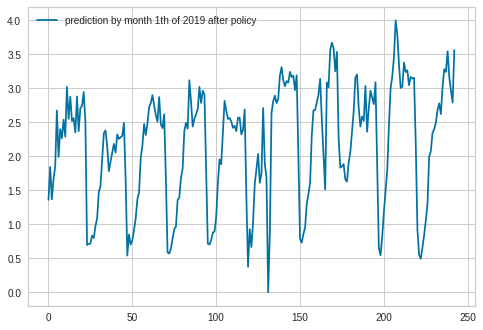

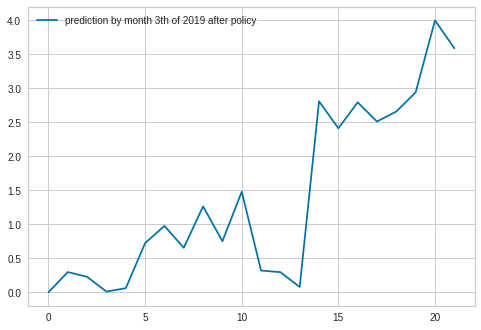

In [218]:
DF19=pd.read_csv('mix2019.csv')
monthvals=DF19.month.unique()


tf=DF19['Congestion'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1913)
DF19['two_wheeled_motor_vehicles']=twmv
DF19['cars_and_taxis']=cat
DF19['buses_and_coaches']=bac
DF19['lgvs']=lgvs

# 19
twmv19=DF19["two_wheeled_motor_vehicles"].values
twmv19=np.round(twmv19*0.8)
cat19=DF19["cars_and_taxis"].values
cat19=np.round(cat19*0.8)
bac19=DF19["buses_and_coaches"].values
bac19=np.round(bac19*0.9)
lgvs19=DF19["lgvs"].values
lgvs19=np.round(lgvs19*0.8)
co19=DF19["CO"].values
co19=co19-19
par19=DF19["Particle Count"].values
par19=par19 -10
pm119=DF19["PM1"].values
pm119=pm119 -10
pm1019=DF19["PM10"].values
pm1019=pm1019 -21
pm419=DF19["PM 4"].values
pm419=pm419 -23
no19=DF19["NO"].values
no19=no19 -19
nox19=DF19["NOx"].values
nox19=nox19 -24
no219=DF19["NO2"].values
no219=no219 -25


DF19["two_wheeled_motor_vehicles"]=twmv19
DF19["cars_and_taxis"]=cat19
DF19["buses_and_coaches"]=bac19
DF19["lgvs"]=lgvs19
DF19["CO"]=co19
DF19["Particle Count"]=par19
DF19["PM1"]=pm119
DF19["PM10"]=pm1019
DF19["PM 4"]=pm419
DF19["NO"]=no19
DF19["NOx"]=nox19
DF19["NO2"]=no219

labels2019=DF19['NO2']
templ2019=set_tags_no2(labels2019)
DF19.NO2=templ2019
Ys=DF19["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF19.NO2=Ys_of_train


print(monthvals)
for j in monthvals:

  tempdf=DF19.loc[DF2019['month'] == j]
  trainx19=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values19 = scaler.fit_transform(trainx19)
  trainx19 = series_to_supervised(values19, 1, 1)
  trainlab19=tempdf['NO2'].values

  trainx19=trainx19.values
  trainlab19=trainlab19[:36]
  trainx19 = trainx19.reshape((trainx19.shape[0], 1, trainx19.shape[1]))
  trainx19 =trainx19[:,:,:36]
  yhats = model19a.predict(trainx19)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats = scaler.fit_transform(yhats)
  plt.plot(yhats, label='prediction by month '+str(j)+'th of 2019 after policy')
  plt.legend()
  plt.show()




#very unhealty before and after policy

   year  month  day  hour  ...  Rain Acc        CO        PM1        NO2
0  2018      1   16    12  ...  0.000755  2.310081  10.539002  50.431668
1  2018      1   16    13  ...  0.000377 -3.383154   8.436886  46.707554
2  2018      1   16    14  ...  0.000000 -2.070059  12.389496  41.888584
3  2018      1   16    15  ...  0.000000 -4.015489  14.354454  43.443494
4  2018      1   16    16  ...  0.000000 -0.412790   2.969241  45.480956

[5 rows x 26 columns] Index(['year', 'month', 'day', 'hour', 'Rain Duration', 'Traffic Flow',
       'Solar Radiation', 'Particle Count', 'Max Wind Speed', 'Average Speed',
       'Solar Diffuse Radiation', 'Congestion', 'O3', 'PM2_5', 'Wind Speed',
       'Pressure', 'Brood', 'NO', 'NOx', 'PM 4', 'PM10', 'Wind Direction',
       'Rain Acc', 'CO', 'PM1', 'NO2'],
      dtype='object')


Text(0.5, 1.0, 'combiined after policy')

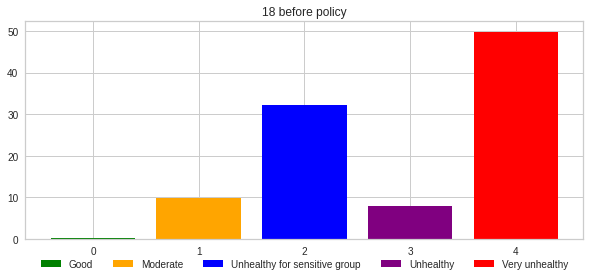

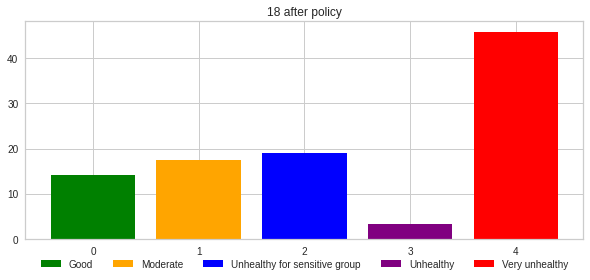

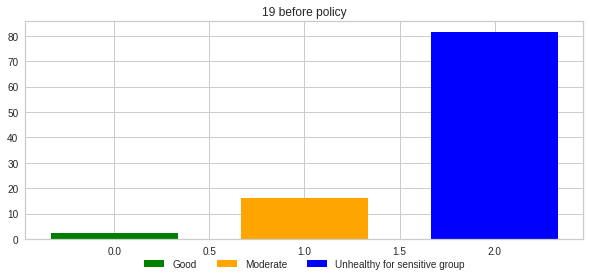

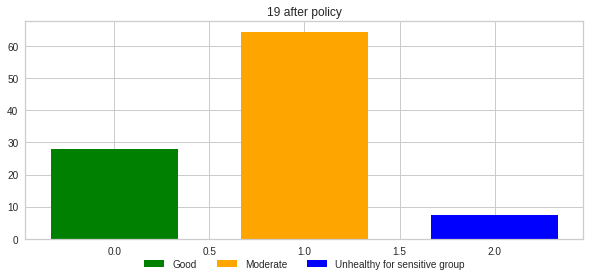

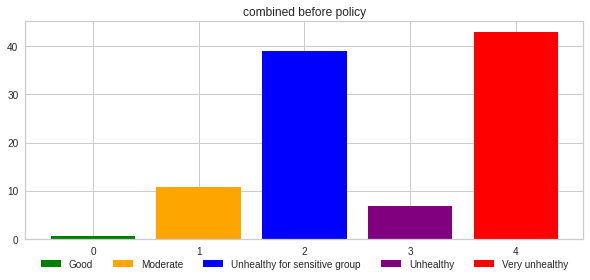

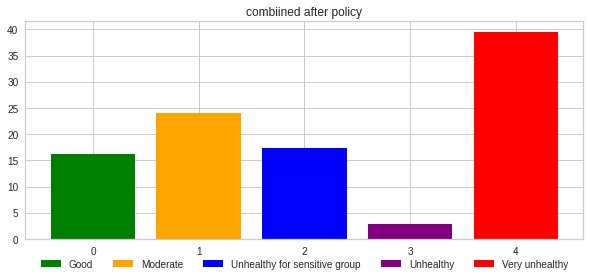

In [219]:

DF2018=pd.read_csv('mix2018.csv')
# print(DF2018.head())
DF2019=pd.read_csv('mix2019.csv')
# print(DF2019.head())
DF2018.reset_index(drop=True, inplace=True)
DF2019.reset_index(drop=True, inplace=True)



DFcom=pd.concat([DF2018, DF2019], axis=0)

print(DFcom.head(5),DFcom.columns)

# setting tags for No2

labels2018=DF2018['NO2']
templ2018=set_tags_no2(labels2018)
DF2018.NO2=templ2018

labels2019=DF2019['NO2']
templ2019=set_tags_no2(labels2019)
DF2019.NO2=templ2019

labelscom=DFcom['NO2'].values
templcom=set_tags_no2(labelscom)
DFcom.NO2=templcom


#combined
Ys=DFcom["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

B4c=Ys_of_train

#19
Ys=DF2019["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

B419=Ys_of_train

#combined
Ys=DF2018["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

B418=Ys_of_train

color=['green','orange','blue','purple','red']
labels=['Good','Moderate','Unhealthy for sensitive group','Unhealthy','Very unhealthy']
fig, ax = plt.subplots(1,1, figsize=(10,4))

hist, bins = np.histogram(B418,bins=5,density=True)
hist=hist/hist.sum()
for w,x,y,z in zip(np.ceil(bins[:-1]), hist.astype(np.float32)*100, color, labels):
    ax.bar(w,x, color = y, width=(bins[1]-bins[0]), label = z)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.set_title('18 before policy')


fig, ax = plt.subplots(1,1, figsize=(10,4))

hist, bins = np.histogram(Af18,bins=5,density=True)
hist=hist/hist.sum()
for w,x,y,z in zip(np.ceil(bins[:-1]), hist.astype(np.float32)*100, color, labels):
    ax.bar(w,x, color = y, width=(bins[1]-bins[0]), label = z)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.set_title('18 after policy')

fig, ax = plt.subplots(1,1, figsize=(10,4))

hist, bins = np.histogram(B419,bins=3,density=True)
hist=hist/hist.sum()
for w,x,y,z in zip(np.ceil(bins[:-1]), hist.astype(np.float32)*100, color, labels):
    ax.bar(w,x, color = y, width=(bins[1]-bins[0]), label = z)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.set_title('19 before policy')

fig, ax = plt.subplots(1,1, figsize=(10,4))

hist, bins = np.histogram(Af19,bins=3,density=True)
hist=hist/hist.sum()
for w,x,y,z in zip(np.ceil(bins[:-1]), hist.astype(np.float32)*100, color, labels):
    ax.bar(w,x, color = y, width=(bins[1]-bins[0]), label = z)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.set_title('19 after policy')

fig, ax = plt.subplots(1,1, figsize=(10,4))

hist, bins = np.histogram(B4c,bins=5,density=True)
hist=hist/hist.sum()
for w,x,y,z in zip(np.ceil(bins[:-1]), hist.astype(np.float32)*100, color, labels):
    ax.bar(w,x, color = y, width=(bins[1]-bins[0]), label = z)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.set_title('combined before policy')

fig, ax = plt.subplots(1,1, figsize=(10,4))

hist, bins = np.histogram(Afc,bins=5,density=True)
hist=hist/hist.sum()
for w,x,y,z in zip(np.ceil(bins[:-1]), hist.astype(np.float32)*100, color, labels):
    ax.bar(w,x, color = y, width=(bins[1]-bins[0]), label = z)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.set_title('combiined after policy')







#culminative plot

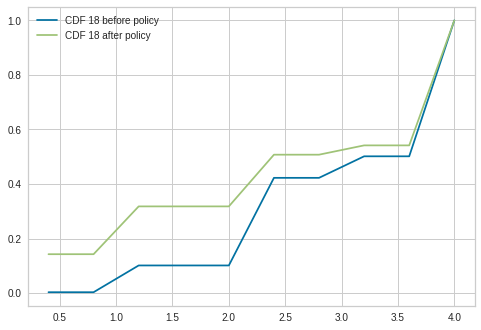

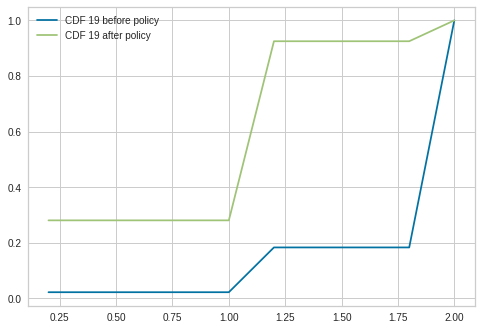

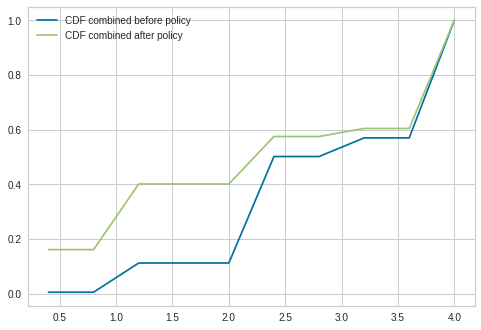

In [220]:
count, bins_count = np.histogram(B418, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF 18 before policy")
plt.legend()

count, bins_count = np.histogram(Af18, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF 18 after policy")
plt.legend()
plt.show()


count, bins_count = np.histogram(B419, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF 19 before policy")
plt.legend()

count, bins_count = np.histogram(Af19, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF 19 after policy")
plt.legend()
plt.show()


count, bins_count = np.histogram(B4c, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF combined before policy")
plt.legend()

count, bins_count = np.histogram(Afc, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF combined after policy")
plt.legend()
plt.show()




#box plot

No handles with labels found to put in legend.
No handles with labels found to put in legend.


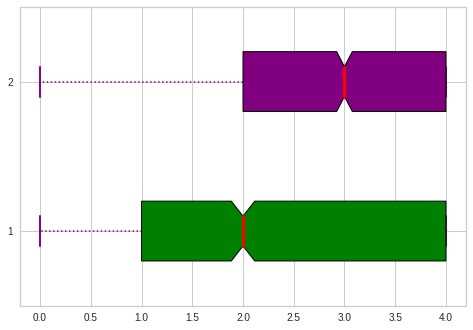

No handles with labels found to put in legend.
No handles with labels found to put in legend.


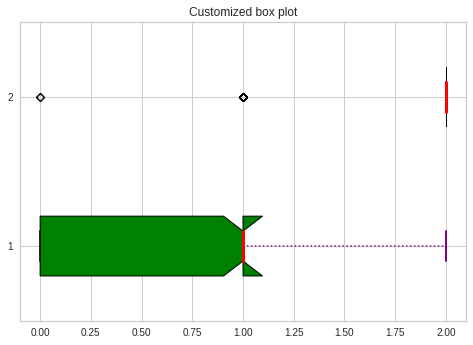

No handles with labels found to put in legend.
No handles with labels found to put in legend.


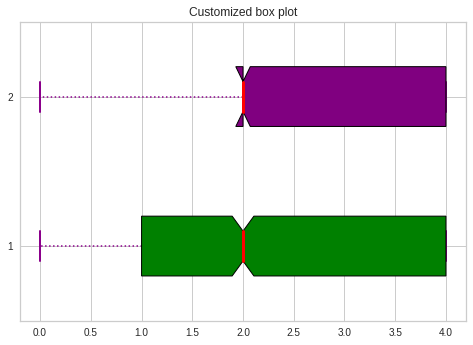

In [221]:
 
colors = ['purple']
 
data=B418

bp=plt.boxplot(data, patch_artist = True,positions=[2],
                notch ='True', vert = 0,widths=0.4)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
plt.legend()

colors = ['green']
data=Af18

bp=plt.boxplot(data, patch_artist = True,positions=[1],
                notch ='True', vert = 0,widths=0.4)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
plt.legend()
plt.show()


colors = ['purple']
data=B419

bp=plt.boxplot(data, patch_artist = True,
                notch ='True', vert = 0,positions=[2],widths=0.4)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
plt.title("Customized box plot")
plt.legend()



colors = ['green']
data=Af19

bp=plt.boxplot(data, patch_artist = True,
                notch ='True', vert = 0,positions=[1],widths=0.4)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
plt.title("Customized box plot")
plt.legend()

plt.show()


colors = ['purple']
data=B4c

bp=plt.boxplot(data, patch_artist = True,
                notch ='True', vert = 0,positions=[2],widths=0.4)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
plt.title("Customized box plot")
plt.legend()



colors = ['green']
data=Afc

bp=plt.boxplot(data, patch_artist = True,
                notch ='True', vert = 0,positions=[1],widths=0.4)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
plt.title("Customized box plot")
plt.legend()

plt.show()

#prediction based on dadys feature sequence

the x vector defines sequences of features after the last day that lstm had trained by

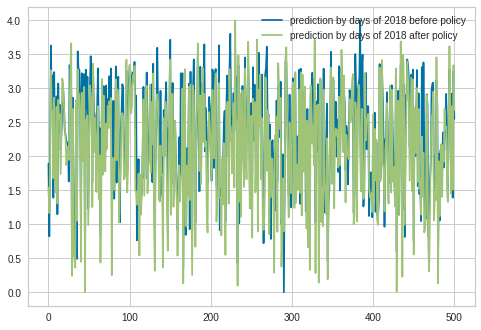

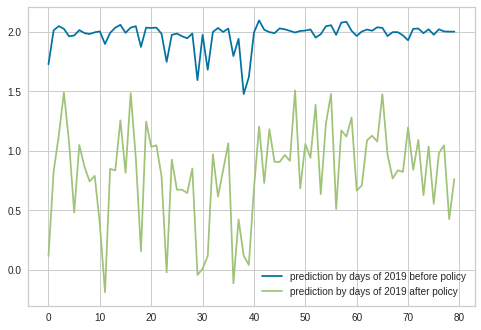

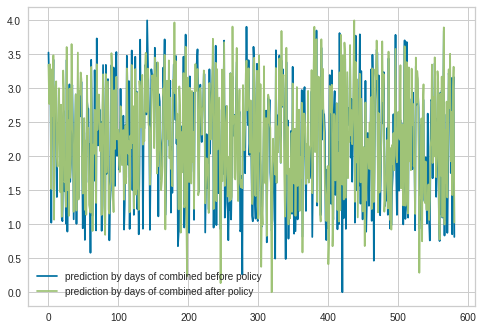

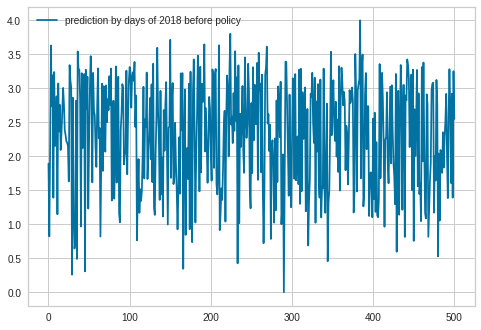

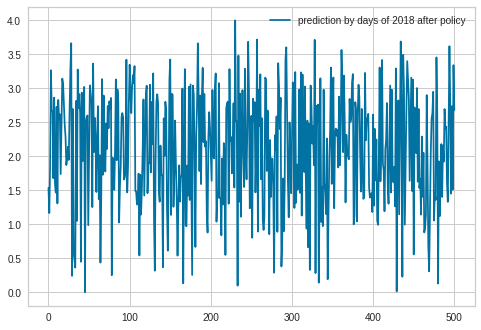

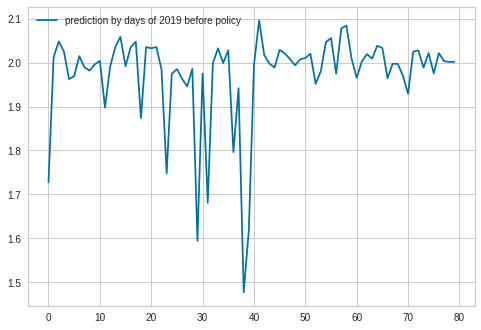

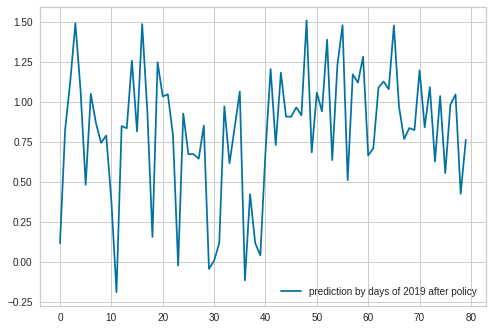

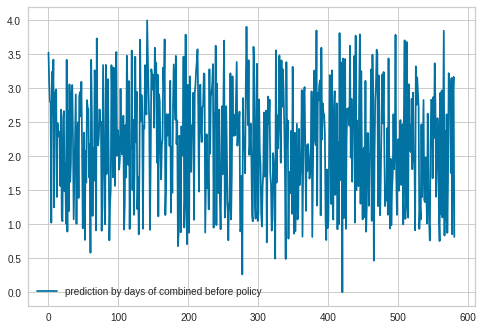

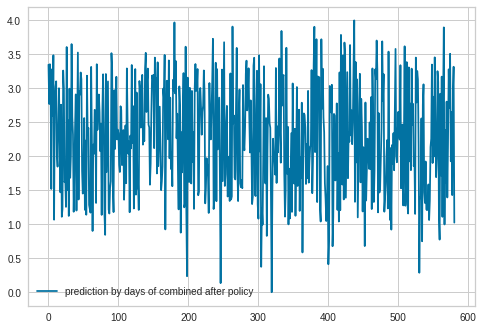

In [222]:
scaler = MinMaxScaler(feature_range=(0, 4))
yhat18 = scaler.fit_transform(yhat18)
yhat18af = scaler.fit_transform(yhat18af)
yhatc = scaler.fit_transform(yhatc)
yhatcaf = scaler.fit_transform(yhatcaf)
plt.plot(yhat18, label='prediction by days of 2018 before policy')
plt.plot(yhat18af, label='prediction by days of 2018 after policy')
plt.legend()
plt.show()

plt.plot(yhat19, label='prediction by days of 2019 before policy')
plt.plot(yhat19af, label='prediction by days of 2019 after policy')
plt.legend()
plt.show()

plt.plot(yhatc, label='prediction by days of combined before policy')
plt.plot(yhatcaf, label='prediction by days of combined after policy')
plt.legend()
plt.show()

plt.plot(yhat18, label='prediction by days of 2018 before policy')
plt.legend()
plt.show()

plt.plot(yhat18af, label='prediction by days of 2018 after policy')
plt.legend()
plt.show()

plt.plot(yhat19, label='prediction by days of 2019 before policy')
plt.legend()
plt.show()

plt.plot(yhat19af, label='prediction by days of 2019 after policy')
plt.legend()
plt.show()


plt.plot(yhatc, label='prediction by days of combined before policy')
plt.legend()
plt.show()

plt.plot(yhatcaf, label='prediction by days of combined after policy')
plt.legend()
plt.show()





month

[ 1  2  3  4 10 11 12]


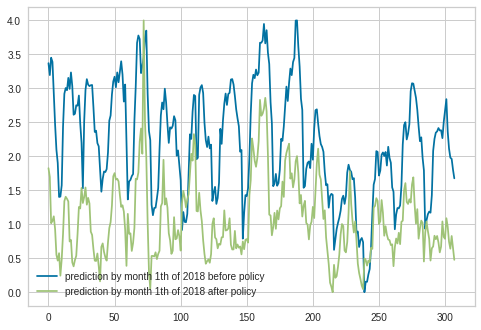

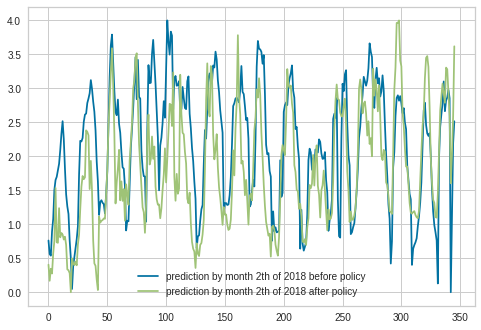

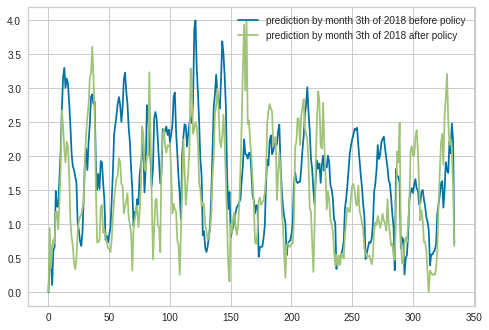

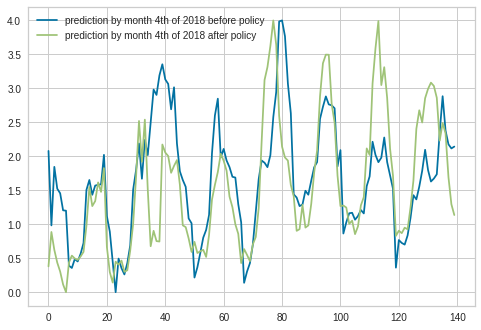

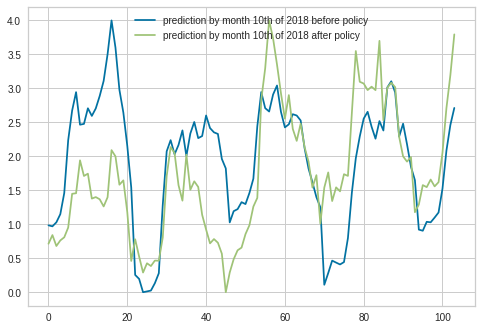

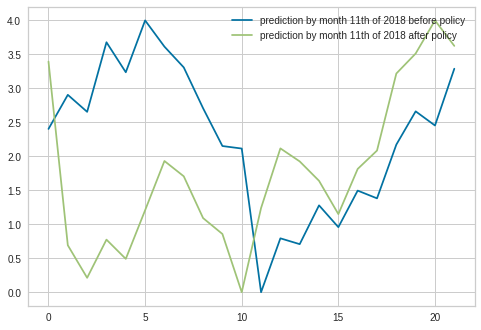

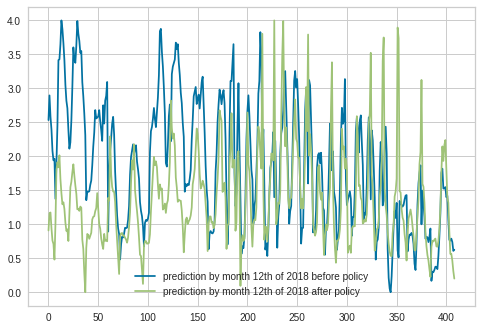

[1 3]


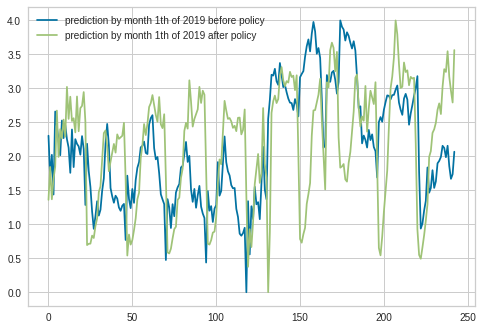

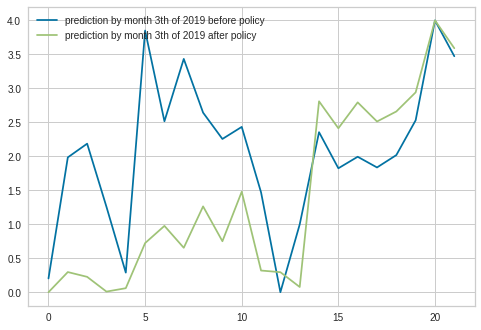

In [223]:
DF18b=pd.read_csv('mix2018.csv')
monthvals=DF18b.month.unique()


tf=DF18b['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF18b['two_wheeled_motor_vehicles']=twmv
DF18b['cars_and_taxis']=cat
DF18b['buses_and_coaches']=bac
DF18b['lgvs']=lgvs
DF18b.drop('Traffic Flow',axis=1)
labels2018=DF18b['NO2']
templ2018=set_tags_no2(labels2018)
DF18b.NO2=templ2018
Ys=DF18b["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF18b.NO2=Ys_of_train

#after


DF18a=pd.read_csv('mix2018.csv')
monthvals=DF18a.month.unique()


tf=DF18a['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF18a['two_wheeled_motor_vehicles']=twmv
DF18a['cars_and_taxis']=cat
DF18a['buses_and_coaches']=bac
DF18a['lgvs']=lgvs

# 18
twmv18=DF18a["two_wheeled_motor_vehicles"].values
twmv18=np.round(twmv18*0.8)
cat18=DF18a["cars_and_taxis"].values
cat18=np.round(cat18*0.8)
bac18=DF18a["buses_and_coaches"].values
bac18=np.round(bac18*0.9)
lgvs18=DF18a["lgvs"].values
lgvs18=np.round(lgvs18*0.8)
co18=DF18a["CO"].values
co18=co18-18
pm2518=DF18a["PM2_5"].values
pm2518=pm2518 -16
par18=DF18a["Particle Count"].values
par18=par18 -10
pm118=DF18a["PM1"].values
pm118=pm118 -10
pm1018=DF18a["PM10"].values
pm1018=pm1018 -21
pm418=DF18a["PM 4"].values
pm418=pm418 -23
o318=DF18a["O3"].values
o318=o318 -29
no18=DF18a["NO"].values
no18=no18 -18
nox18=DF18a["NOx"].values
nox18=nox18 -24
no218=DF18a["NO2"].values
no218=no218 -25


DF18a["two_wheeled_motor_vehicles"]=twmv18
DF18a["cars_and_taxis"]=cat18
DF18a["buses_and_coaches"]=bac18
DF18a["lgvs"]=lgvs18
DF18a["CO"]=co18
DF18a["PM2_5"]=pm2518
DF18a["Particle Count"]=par18
DF18a["PM1"]=pm118
DF18a["PM10"]=pm1018
DF18a["PM 4"]=pm418
DF18a["O3"]=o318
DF18a["NO"]=no18
DF18a["NOx"]=nox18
DF18a["NO2"]=no218

labels2018=DF18a['NO2']
templ2018=set_tags_no2(labels2018)
DF18a.NO2=templ2018
Ys=DF18a["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF18a.NO2=Ys_of_train





print(monthvals)
for j in monthvals:
  #before
  tempdf=DF18b.loc[DF2018['month'] == j]
  trainx18=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values18 = scaler.fit_transform(trainx18)
  trainx18 = series_to_supervised(values18, 1, 1)
  trainlab18=tempdf['NO2'].values

  trainx18=trainx18.values
  trainlab18=trainlab18[:48]
  trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
  trainx18 =trainx18[:,:,:48]
  yhats = model18.predict(trainx18)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats = scaler.fit_transform(yhats)

  #after
  tempdf=DF18a.loc[DF2018['month'] == j]
  trainx18=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values18 = scaler.fit_transform(trainx18)
  trainx18 = series_to_supervised(values18, 1, 1)
  trainlab18=tempdf['NO2'].values

  trainx18=trainx18.values
  trainlab18=trainlab18[:52]
  trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
  trainx18 =trainx18[:,:,:52]
  yhats2 = model18a.predict(trainx18)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats2 = scaler.fit_transform(yhats2)
  plt.plot(yhats, label='prediction by month '+str(j)+'th of 2018 before policy')
  plt.plot(yhats2, label='prediction by month '+str(j)+'th of 2018 after policy')
  plt.legend()
  plt.show()







#2019
DF19b=pd.read_csv('mix2019.csv')
monthvals=DF19b.month.unique()


tf=DF19b['Congestion'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1913)
DF19b['two_wheeled_motor_vehicles']=twmv
DF19b['cars_and_taxis']=cat
DF19b['buses_and_coaches']=bac
DF19b['lgvs']=lgvs
DF19b.drop("Congestion",axis=1)

labels2019=DF19b['NO2']
templ2019=set_tags_no2(labels2019)
DF19b.NO2=templ2019
Ys=DF19b["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF19b.NO2=Ys_of_train

  
#19after
DF19a=pd.read_csv('mix2019.csv')
monthvals=DF19a.month.unique()


tf=DF19a['Congestion'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1913)
DF19a['two_wheeled_motor_vehicles']=twmv
DF19a['cars_and_taxis']=cat
DF19a['buses_and_coaches']=bac
DF19a['lgvs']=lgvs

# 19
twmv19=DF19a["two_wheeled_motor_vehicles"].values
twmv19=np.round(twmv19*0.8)
cat19=DF19a["cars_and_taxis"].values
cat19=np.round(cat19*0.8)
bac19=DF19a["buses_and_coaches"].values
bac19=np.round(bac19*0.9)
lgvs19=DF19a["lgvs"].values
lgvs19=np.round(lgvs19*0.8)
co19=DF19a["CO"].values
co19=co19-19
par19=DF19a["Particle Count"].values
par19=par19 -10
pm119=DF19a["PM1"].values
pm119=pm119 -10
pm1019=DF19a["PM10"].values
pm1019=pm1019 -21
pm419=DF19a["PM 4"].values
pm419=pm419 -23
no19=DF19a["NO"].values
no19=no19 -19
nox19=DF19a["NOx"].values
nox19=nox19 -24
no219=DF19a["NO2"].values
no219=no219 -25


DF19a["two_wheeled_motor_vehicles"]=twmv19
DF19a["cars_and_taxis"]=cat19
DF19a["buses_and_coaches"]=bac19
DF19a["lgvs"]=lgvs19
DF19a["CO"]=co19
DF19a["Particle Count"]=par19
DF19a["PM1"]=pm119
DF19a["PM10"]=pm1019
DF19a["PM 4"]=pm419
DF19a["NO"]=no19
DF19a["NOx"]=nox19
DF19a["NO2"]=no219

labels2019=DF19a['NO2']
templ2019=set_tags_no2(labels2019)
DF19a.NO2=templ2019
Ys=DF19a["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF19a.NO2=Ys_of_train

print(monthvals)
for j in monthvals:
  #before
  tempdf=DF19b.loc[DF2019['month'] == j]
  trainx19=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values19 = scaler.fit_transform(trainx19)
  trainx19 = series_to_supervised(values19, 1, 1)
  trainlab19=tempdf['NO2'].values

  trainx19=trainx19.values
  trainlab19=trainlab19[:40]
  trainx19 = trainx19.reshape((trainx19.shape[0], 1, trainx19.shape[1]))
  trainx19 =trainx19[:,:,:40]
  tr=np.zeros((trainx19.shape[0],trainx19.shape[1],48))
  tr[:,:,:trainx19.shape[2]]=trainx19
  yhats = model19.predict(tr)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats = scaler.fit_transform(yhats)




  #after
  tempdf=DF19a.loc[DF2019['month'] == j]
  trainx19=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values19 = scaler.fit_transform(trainx19)
  trainx19 = series_to_supervised(values19, 1, 1)
  trainlab19=tempdf['NO2'].values

  trainx19=trainx19.values
  trainlab19=trainlab19[:36]
  trainx19 = trainx19.reshape((trainx19.shape[0], 1, trainx19.shape[1]))
  trainx19 =trainx19[:,:,:36]
  tr=np.zeros((trainx19.shape[0],trainx19.shape[1],36))
  tr[:,:,:trainx19.shape[2]]=trainx19
  yhats2 = model19a.predict(trainx19)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats2 = scaler.fit_transform(yhats2)  


  plt.plot(yhats, label='prediction by month '+str(j)+'th of 2019 before policy')
  plt.plot(yhats2, label='prediction by month '+str(j)+'th of 2019 after policy')
  plt.legend()
  plt.show()


